## 1. Imports

In [1]:
from functools import partial
from data_prep import data_split_normalize
from mlp.tensor import Tensor
from tqdm import tqdm
from IPython.display import display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import mlp.nn as nn

# for notebook
from tqdm.notebook import tqdm
from IPython.display import display, HTML

## 2. Data Preparation

In [2]:
X_train, y_train, X_valid, y_valid = data_split_normalize('data/data.csv')

# Print a few rows of the raw training and validation data
print(f'Raw training data sample:\n{X_train[:5]}')
print(f'Raw training labels sample:\n{y_train[:5]}')
print(f'Raw validation data sample:\n{X_valid[:5]}')
print(f'Raw validation labels sample:\n{y_valid[:5]}')

Raw training data sample:
[[-0.23310484 -0.20774475 -0.03234363  0.72587014 -0.27075495 -0.27096831
  -0.27115596 -0.27115596 -0.27040029 -0.27086089 -0.27018877 -0.26770103
  -0.26485872 -0.22130465 -0.27111571 -0.27112082 -0.27115596 -0.27115596
  -0.27103699 -0.27114104 -0.23051135 -0.196379   -0.01505366  0.86629635
  -0.27064603 -0.27084627 -0.27115596 -0.27115596 -0.27001851 -0.27081156]
 [-0.21336179 -0.18926992  0.10615172  2.07483943 -0.27064779 -0.27061576
  -0.27061795 -0.27083385 -0.27022212 -0.27085856 -0.26989607 -0.26723412
  -0.26283132 -0.16473922 -0.27112729 -0.27105345 -0.27102848 -0.27110264
  -0.27107947 -0.27113997 -0.202391   -0.14850244  0.17996325  3.06133356
  -0.2703722  -0.26932778 -0.26895916 -0.27023968 -0.26944451 -0.27063857]
 [-0.21200142 -0.17979115  0.11677145  2.18279208 -0.2707101  -0.27060522
  -0.27068948 -0.27091728 -0.27040117 -0.27087427 -0.27022125 -0.26856071
  -0.264376   -0.18988429 -0.27113241 -0.2710577  -0.27102216 -0.27110058
  -0.27109

In [3]:
# Additional dataset statistics
print(f'Training set contains {X_train.shape[0]} samples with {X_train.shape[1]} features each.')
print(f'Validation set contains {X_valid.shape[0]} samples with {X_valid.shape[1]} features each.')

# Checking the distribution of the target variable
print(f'Unique labels in y_train: {set(y_train)}')
print(f'Unique labels in y_valid: {set(y_valid)}')

# Label distribution in training and validation set
print(f'Label distribution in y_train: {dict((label, list(y_train).count(label)) for label in set(y_train))}')
print(f'Label distribution in y_valid: {dict((label, list(y_valid).count(label)) for label in set(y_valid))}')

Training set contains 454 samples with 30 features each.
Validation set contains 114 samples with 30 features each.
Unique labels in y_train: {0, 1}
Unique labels in y_valid: {0, 1}
Label distribution in y_train: {0: 293, 1: 161}
Label distribution in y_valid: {0: 64, 1: 50}


In [4]:
# Convert to Tensors
X_tr, y_tr, X_val, y_val = map(Tensor, (X_train, y_train, X_valid, y_valid))

# Print the data types and shapes after conversion
print(f'X_tr Tensor shape: {X_tr.shape}, type: {X_tr.dtype}')
print(f'y_tr Tensor shape: {y_tr.shape}, type: {y_tr.dtype}')
print(f'X_val Tensor shape: {X_val.shape}, type: {X_val.dtype}')
print(f'y_val Tensor shape: {y_val.shape}, type: {y_val.dtype}')

X_tr Tensor shape: (454, 30), type: float64
y_tr Tensor shape: (454,), type: int64
X_val Tensor shape: (114, 30), type: float64
y_val Tensor shape: (114,), type: int64


## 3. Model & Dataset Creation

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(NeuralNetwork, self).__init__()
        self.dense1 = nn.Linear(in_features=input_shape, out_features=100)
        self.dense2 = nn.Linear(100, 50)
        self.dense3 = nn.Linear(50, 25)
        self.dense4 = nn.Linear(25, output_shape)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.relu(self.dense1(x))
        x = self.relu(self.dense2(x))
        x = self.relu(self.dense3(x))
        # print(self.dense4(x))
        x = self.dense4(x)
        return x

# Create the neural network
input_shape = X_tr.shape[1]  # Replace with the actual input shape
output_shape = 2  # Replace with the actual output shape

network = NeuralNetwork(input_shape, output_shape)
network

NeuralNetwork(
  (dense1): Linear(in_features=30, out_features=100, bias=True)
  (dense2): Linear(in_features=100, out_features=50, bias=True)
  (dense3): Linear(in_features=50, out_features=25, bias=True)
  (dense4): Linear(in_features=25, out_features=2, bias=True)
  (relu): ReLU()
  (softmax): Softmax()
)

In [6]:
# Custom Dataset class
class MyDataset(nn.Dataset):
    def __init__(self, X, y):
        self.X = Tensor(X)
        self.y = Tensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

tr_ds = MyDataset(X_tr, y_tr)
val_ds = MyDataset(X_val, y_val)

# Creating the data loader
bs = 64
tr_dl = nn.DataLoader(tr_ds, batch_size=bs)
val_dl = nn.DataLoader(val_ds, batch_size=bs)

In [7]:
xb, yb = next(iter(tr_dl))
xb.shape, yb

((64, 30),
 mi.Tensor([0 1 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1
  1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]))

In [8]:
xb.numpy().mean(), xb.numpy().std()

(-0.012723408719671918, 0.9684296008236845)

## 4. Training

In [13]:
def fit(epochs, lr, model, loss_func, opt_fn, train_dl, valid_dl, patience=10, use_early_stoping=False):
    recorder = {'tr_loss': [], 'val_loss': [], 'tr_acc': [], 'val_acc': []}
    losses = [[], []]
    # Initialize early stopping parameters
    best_val_loss = float('inf')
    counter_early_stop = 0
    early_stop = False
    fig, axs = plt.subplots(1, 1, figsize=(14, 7))
    p = display(fig,display_id=True)

    opt = opt_fn(model.parameters(), lr=lr, wd=0.01)
    
    for epoch in tqdm(range(epochs)):
        model.train()
        train_tot_loss, train_tot_acc, t_count = 0.,0.,0
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

            # Calculate accuracy & loss
            predicted_labels = preds.argmax(axis=1)
            n = len(xb)
            t_count += n
            train_tot_loss += loss.item()*n
            train_tot_acc  += Tensor.accuracy(predicted_labels, yb).item()*n
            recorder['tr_loss'].append(loss.item())
            recorder['tr_acc'].append(Tensor.accuracy(predicted_labels, yb).item())
            losses[0].append(loss.item())
            

            

        model.eval()
        val_tot_loss, val_tot_acc,v_count = 0.,0.,0
        for xb,yb in valid_dl:
            preds = model(xb)

            pred_labels = preds.argmax(axis=1)
            n = len(xb)
            v_count += n
            val_tot_acc  += Tensor.accuracy(pred_labels, yb).item()*n
            val_tot_loss += loss_func(preds,yb).item()*n
            recorder['val_loss'].append(loss_func(preds,yb).item())
            recorder['val_acc'].append(Tensor.accuracy(pred_labels, yb).item())
            losses[1].append(loss_func(preds,yb).item())

            
        print(f"epoch {epoch + 1:02d}/{epochs:02d} - loss: {train_tot_loss/t_count:.4f} - acc: {train_tot_acc/t_count:.4f} - val_loss: {val_tot_loss/v_count:.4f} - val_acc: {val_tot_acc/v_count:.4f}")
        
        axs.plot(losses[0], c='#983FFF', linestyle='-',  label='Train Loss')
        axs.plot(losses[1], c='#FF9300', linestyle='--', label='Validation Loss')
        
        axs.grid(True)  # Enable gridlines
        axs.set_xlabel('Epochs')
        axs.set_ylabel('Loss')
        axs.set_title('Training and Validation Loss')
        
        p.update(fig)


        if use_early_stoping:
            if recorder['val_loss'][-1] < best_val_loss:
                best_val_loss = recorder['val_loss'][-1]
                counter_early_stop = 0
                # Save the best model
                model.save_weights(path='best_model.pth')
            else:
                counter_early_stop += 1
                if counter_early_stop >= patience:
                    print("Early stopping triggered")
                    early_stop = True
                    
            if early_stop:
                print("Stopped")
                break
            
    return recorder

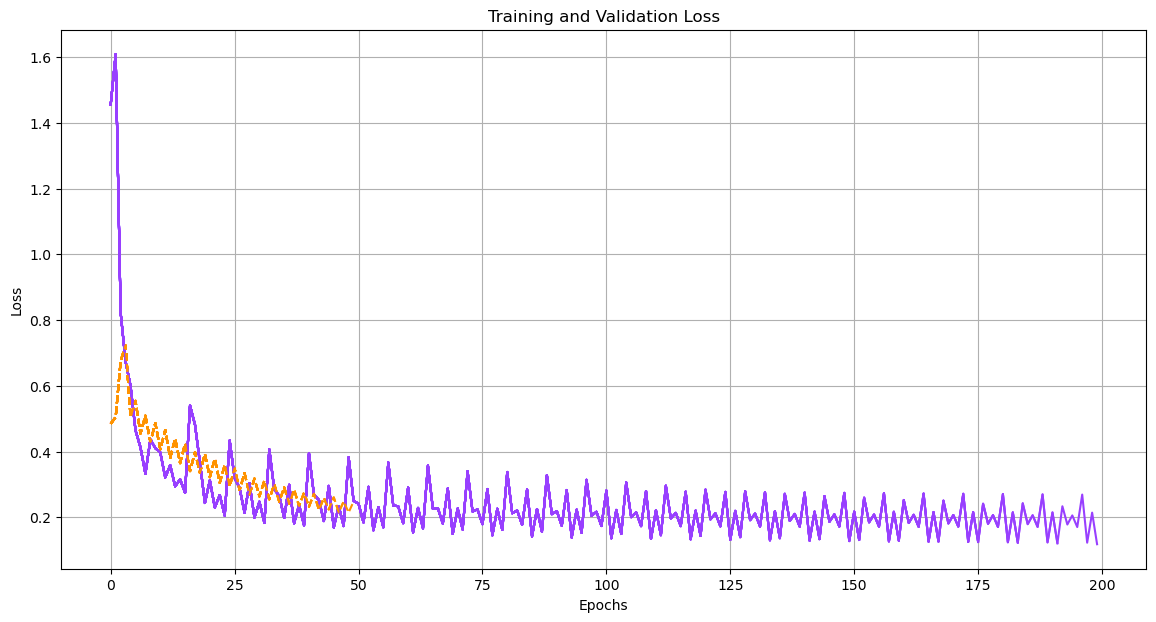

  0%|          | 0/25 [00:00<?, ?it/s]

epoch 01/25 - loss: 0.8558 - acc: 0.5881 - val_loss: 0.4936 - val_acc: 0.7719
epoch 02/25 - loss: 0.3610 - acc: 0.8943 - val_loss: 0.6960 - val_acc: 0.6491
epoch 03/25 - loss: 0.3472 - acc: 0.8700 - val_loss: 0.5266 - val_acc: 0.7544
epoch 04/25 - loss: 0.2853 - acc: 0.8965 - val_loss: 0.4788 - val_acc: 0.7807
epoch 05/25 - loss: 0.2665 - acc: 0.8943 - val_loss: 0.4544 - val_acc: 0.7895
epoch 06/25 - loss: 0.2566 - acc: 0.8987 - val_loss: 0.4326 - val_acc: 0.8070
epoch 07/25 - loss: 0.2480 - acc: 0.9031 - val_loss: 0.4066 - val_acc: 0.8246
epoch 08/25 - loss: 0.2408 - acc: 0.9053 - val_loss: 0.3909 - val_acc: 0.8246
epoch 09/25 - loss: 0.2357 - acc: 0.9053 - val_loss: 0.3659 - val_acc: 0.8421
epoch 10/25 - loss: 0.2304 - acc: 0.9097 - val_loss: 0.3605 - val_acc: 0.8596
epoch 11/25 - loss: 0.2278 - acc: 0.9119 - val_loss: 0.3471 - val_acc: 0.8596
epoch 12/25 - loss: 0.2243 - acc: 0.9119 - val_loss: 0.3287 - val_acc: 0.8596
epoch 13/25 - loss: 0.2205 - acc: 0.9141 - val_loss: 0.3184 - va

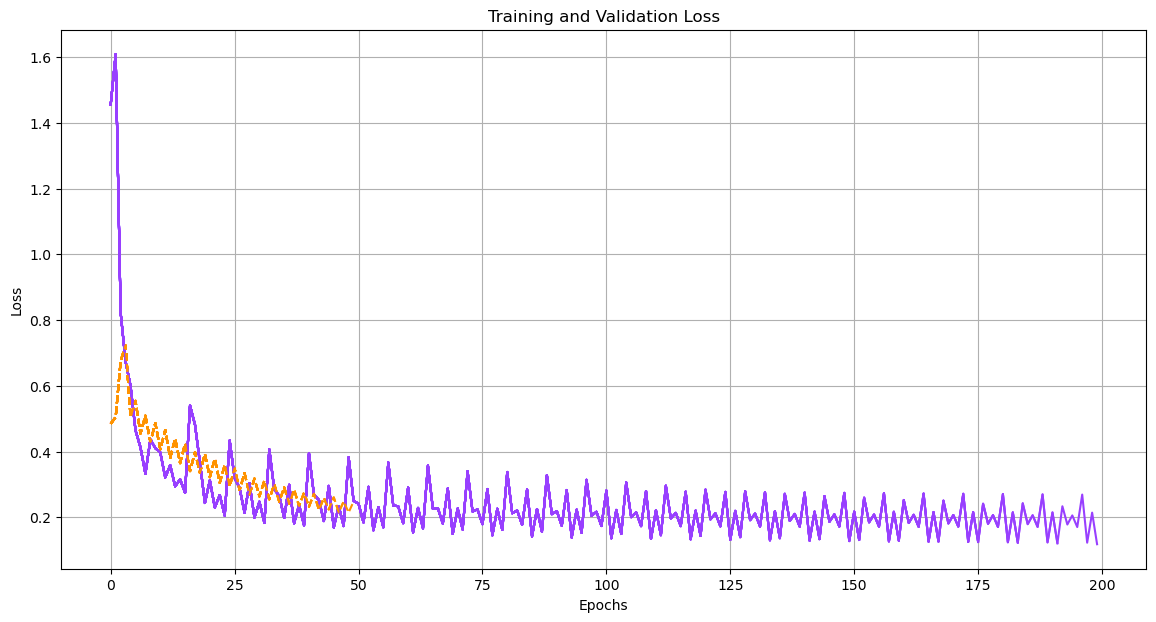

In [14]:
lr = 0.05
network = NeuralNetwork(input_shape, output_shape)
recorder = fit(25, lr, network, nn.CrossEntropyLoss(), nn.SGD, tr_dl, val_dl)

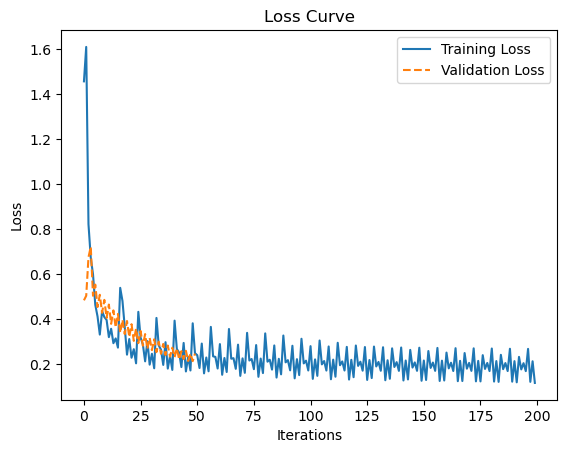

In [15]:
## plt.figure(figsize=(10, 7))
plt.plot(recorder['tr_loss'], label='Training Loss')
plt.plot(recorder['val_loss'], label='Validation Loss', linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

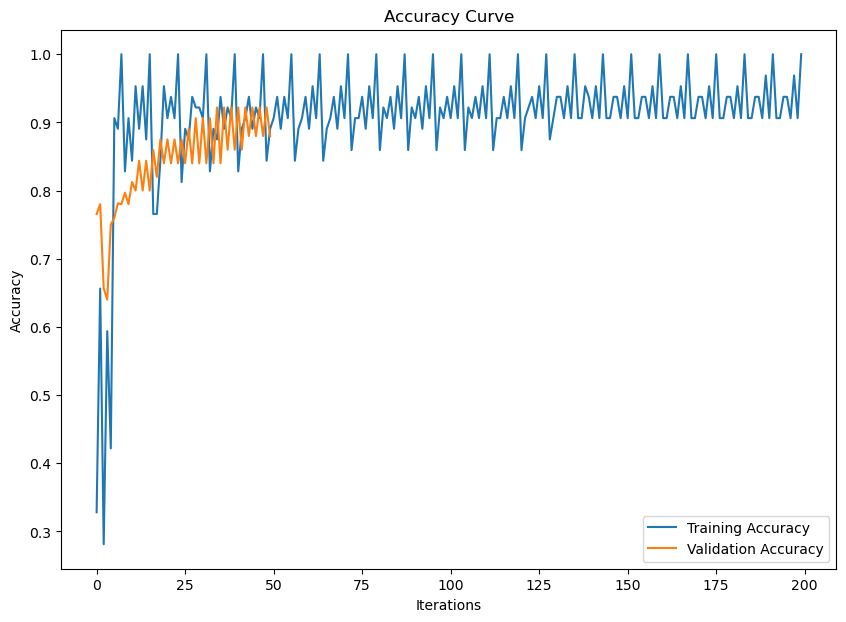

In [16]:
plt.figure(figsize=(10, 7))
plt.plot(recorder['tr_acc'], label='Training Accuracy')
plt.plot(recorder['val_acc'], label='Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

## 5. Save Model Weights

In [17]:
network.save_weights(path='model_params.pkl')

In [ ]:
xb, yb = next(iter(val_dl))
xb.shape

In [18]:
probs = network(xb)
pred_labels = probs.argmax(axis=1)
Tensor.accuracy(pred_labels, yb).item()

0.90625

In [19]:
network2 = NeuralNetwork(input_shape, output_shape)

In [20]:
probs = network2(xb)
pred_labels = probs.argmax(axis=1)
Tensor.accuracy(pred_labels, yb).item()

0.328125

In [22]:
network2.set_parameters(network.parameters())

In [23]:
probs = network2(xb)
pred_labels = probs.argmax(axis=1)
Tensor.accuracy(pred_labels, yb).item()

0.90625

## 6. Results Interpretation

In [ ]:
from functools import partial
from data_prep import data_split_normalize
from mlp.tensor import Tensor
from tqdm import tqdm
from IPython.display import display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import mlp.nn as nn

# for notebook
from tqdm.notebook import tqdm
from IPython.display import display, HTML

X_train, y_train, X_valid, y_valid = data_split_normalize('data/data.csv')

# Print a few rows of the raw training and validation data
print(f'Raw training data sample:\n{X_train[:5]}')
print(f'Raw training labels sample:\n{y_train[:5]}')
print(f'Raw validation data sample:\n{X_valid[:5]}')
print(f'Raw validation labels sample:\n{y_valid[:5]}')

# Additional dataset statistics
print(f'Training set contains {X_train.shape[0]} samples with {X_train.shape[1]} features each.')
print(f'Validation set contains {X_valid.shape[0]} samples with {X_valid.shape[1]} features each.')

# Checking the distribution of the target variable
print(f'Unique labels in y_train: {set(y_train)}')
print(f'Unique labels in y_valid: {set(y_valid)}')

# Label distribution in training and validation set
print(f'Label distribution in y_train: {dict((label, list(y_train).count(label)) for label in set(y_train))}')
print(f'Label distribution in y_valid: {dict((label, list(y_valid).count(label)) for label in set(y_valid))}')

# Convert to Tensors
X_tr, y_tr, X_val, y_val = map(Tensor, (X_train, y_train, X_valid, y_valid))

# Print the data types and shapes after conversion
print(f'X_tr Tensor shape: {X_tr.shape}, type: {X_tr.dtype}')
print(f'y_tr Tensor shape: {y_tr.shape}, type: {y_tr.dtype}')
print(f'X_val Tensor shape: {X_val.shape}, type: {X_val.dtype}')
print(f'y_val Tensor shape: {y_val.shape}, type: {y_val.dtype}')

class NeuralNetwork(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(NeuralNetwork, self).__init__()
        self.dense1 = nn.Linear(in_features=input_shape, out_features=100)
        self.dense2 = nn.Linear(100, 50)
        self.dense3 = nn.Linear(50, 25)
        self.dense4 = nn.Linear(25, output_shape)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.relu(self.dense1(x))
        x = self.relu(self.dense2(x))
        x = self.relu(self.dense3(x))
        # print(self.dense4(x))
        x = self.dense4(x)
        return x

# Create the neural network
input_shape = X_tr.shape[1]  # Replace with the actual input shape
output_shape = 2  # Replace with the actual output shape

network = NeuralNetwork(input_shape, output_shape)
network

# Custom Dataset class
class MyDataset(nn.Dataset):
    def __init__(self, X, y):
        self.X = Tensor(X)
        self.y = Tensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

tr_ds = MyDataset(X_tr, y_tr)
val_ds = MyDataset(X_val, y_val)

# Creating the data loader
bs = 64
tr_dl = nn.DataLoader(tr_ds, batch_size=bs)
val_dl = nn.DataLoader(val_ds, batch_size=bs)

xb, yb = next(iter(tr_dl))
xb.shape, yb

xb.numpy().mean(), xb.numpy().std()

def fit(epochs, lr, model, loss_func, opt_fn, train_dl, valid_dl, patience=10, use_early_stoping=False):
    recorder = {'tr_loss': [], 'val_loss': [], 'tr_acc': [], 'val_acc': []}
    losses = [[], []]
    # Initialize early stopping parameters
    best_val_loss = float('inf')
    counter_early_stop = 0
    early_stop = False
    fig, axs = plt.subplots(1, 1, figsize=(14, 7))
    p = display(fig,display_id=True)

    opt = opt_fn(model.parameters(), lr=lr, wd=0.01)
    
    for epoch in tqdm(range(epochs)):
        model.train()
        train_tot_loss, train_tot_acc, t_count = 0.,0.,0
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

            # Calculate accuracy & loss
            predicted_labels = preds.argmax(axis=1)
            n = len(xb)
            t_count += n
            train_tot_loss += loss.item()*n
            train_tot_acc  += Tensor.accuracy(predicted_labels, yb).item()*n
            recorder['tr_loss'].append(loss.item())
            recorder['tr_acc'].append(Tensor.accuracy(predicted_labels, yb).item())
            losses[0].append(loss.item())
            

            

        model.eval()
        val_tot_loss, val_tot_acc,v_count = 0.,0.,0
        for xb,yb in valid_dl:
            preds = model(xb)

            pred_labels = preds.argmax(axis=1)
            n = len(xb)
            v_count += n
            val_tot_acc  += Tensor.accuracy(pred_labels, yb).item()*n
            val_tot_loss += loss_func(preds,yb).item()*n
            recorder['val_loss'].append(loss_func(preds,yb).item())
            recorder['val_acc'].append(Tensor.accuracy(pred_labels, yb).item())
            losses[1].append(loss_func(preds,yb).item())

            
        print(f"epoch {epoch + 1:02d}/{epochs:02d} - loss: {train_tot_loss/t_count:.4f} - acc: {train_tot_acc/t_count:.4f} - val_loss: {val_tot_loss/v_count:.4f} - val_acc: {val_tot_acc/v_count:.4f}")
        
        axs.plot(losses[0], c='#983FFF', linestyle='-',  label='Train Loss')
        axs.plot(losses[1], c='#FF9300', linestyle='--', label='Validation Loss')
        
        axs.grid(True)  # Enable gridlines
        axs.set_xlabel('Epochs')
        axs.set_ylabel('Loss')
        axs.set_title('Training and Validation Loss')
        
        p.update(fig)


        if use_early_stoping:
            if recorder['val_loss'][-1] < best_val_loss:
                best_val_loss = recorder['val_loss'][-1]
                counter_early_stop = 0
                # Save the best model
                model.save_weights(path='best_model.pth')
            else:
                counter_early_stop += 1
                if counter_early_stop >= patience:
                    print("Early stopping triggered")
                    early_stop = True
                    
            if early_stop:
                print("Stopped")
                break
            
    return recorder

lr = 0.05
network = NeuralNetwork(input_shape, output_shape)
recorder = fit(25, lr, network, nn.CrossEntropyLoss(), nn.SGD, tr_dl, val_dl)

## plt.figure(figsize=(10, 7))
plt.plot(recorder['tr_loss'], label='Training Loss')
plt.plot(recorder['val_loss'], label='Validation Loss', linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(recorder['tr_acc'], label='Training Accuracy')
plt.plot(recorder['val_acc'], label='Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

network.save_weights(path='model_params.pkl')

xb, yb = next(iter(val_dl))
xb.shape

probs = network(xb)
pred_labels = probs.argmax(axis=1)
Tensor.accuracy(pred_labels, yb).item()

network2 = NeuralNetwork(input_shape, output_shape)

probs = network2(xb)
pred_labels = probs.argmax(axis=1)
Tensor.accuracy(pred_labels, yb).item()

network2.set_parameters(network.parameters())

probs = network2(xb)
pred_labels = probs.argmax(axis=1)
Tensor.accuracy(pred_labels, yb).item()